# Coexisting processes (SIR + UAU) + multilayer (AUCS)

This experiment shows the difference between SIR and SIR + UAU

In [1]:
import matplotlib.pyplot as plt
import network_diffusion as nd
import numpy as np
import pandas as pd

from tqdm import tqdm
from utils import functions, models, networks

%load_ext autoreload
%autoreload 2

In [2]:
N_EPOCHS = 60
N_REPETITIONS = 50
PATIENCE = None

# ALFA, BETA are SIR parameters with values from sec. 2.3.1 in
# https://www.mdpi.com/1099-4300/25/2/231.
# GAMMA and EPSILON stands from awareness induced by mass media.
# DELTA is a mass media factor + rate of symptomatic infections from paper: 
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0249090.
# LAMBDA is a coefficient that makes ALPHA weaken; ALPHA*LAMBDA -> ALPHA'
ALPHA = 0.19
BETA = 0.10
LAMBDAS = [1, 0.35, 0.1] # reduction: no, by masks, by lockdown

GAMMA = 0.01
DELTA = GAMMA + 1 - 0.3
EPSILON = GAMMA

In [3]:
functions.set_seed(42)

# net = networks.get_aucs_2_network()
net = networks.get_sf_net()
# net = networks.get_er_net()
print(net)

network parameters
--------------------------------------------
general parameters:
	number of layers: 2
	number of actors: 1000

layer 'awareness' parameters:
	graph type - <class 'networkx.classes.digraph.DiGraph'>
	number of nodes - 1000
	number of edges - 1634
	average degree - 3.268
	clustering coefficient - 0.0957

layer 'contagion' parameters:
	graph type - <class 'networkx.classes.digraph.DiGraph'>
	number of nodes - 1000
	number of edges - 1723
	average degree - 3.446
	clustering coefficient - 0.0713


In [4]:
results = {}

for L in LAMBDAS:
    print(f"Model with lambda: {L}")
    model = models.SIR_UAModel(
        alpha = ALPHA,
        beta = BETA,
        alpha_prime = ALPHA * L,
        beta_prime = BETA,
        gamma = GAMMA,
        delta = DELTA,
        epsilon = EPSILON,
        ill_seeds = 5,
        aware_seeds = 5,
    )

    all_logs = []
    for i in tqdm(range(N_REPETITIONS)):
        experiment = nd.Simulator(model, net.copy())
        run_logs = experiment.perform_propagation(n_epochs=N_EPOCHS, patience=PATIENCE)
        all_logs.append(run_logs._global_stats_converted)

    mean_contagion = functions.get_mean_log([log["contagion"] for log in all_logs])
    mean_awareness = functions.get_mean_log([log["awareness"] for log in all_logs])
    mean_core = pd.DataFrame([mean_contagion["I"], mean_awareness["A"]]).T

    std_contagion = functions.get_std_log([log["contagion"] for log in all_logs])
    std_awareness = functions.get_std_log([log["awareness"] for log in all_logs])
    std_core = pd.DataFrame([std_contagion["I"], std_awareness["A"]]).T

    results[L] = {"mean": mean_core, "std": std_core}

print(model)

Model with lambda: 1


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


Model with lambda: 0.35


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


Model with lambda: 0.1


100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


============================================\SIR-UA Model
--------------------------------------------
compartmental model
--------------------------------------------
processes, their states and initial sizes:
	'contagion': [S:95%, I:5%, R:0%]
	'awareness': [U:95%, A:5%]
--------------------------------------------
process 'contagion' transitions with nonzero weight:
	from S to I with probability 0.19 and constrains ['awareness.U']
	from I to R with probability 0.1 and constrains ['awareness.U']
	from S to I with probability 0.019000000000000003 and constrains ['awareness.A']
	from I to R with probability 0.1 and constrains ['awareness.A']
--------------------------------------------
process 'awareness' transitions with nonzero weight:
	from U to A with probability 0.01 and constrains ['contagion.S']
	from U to A with probability 0.71 and constrains ['contagion.I']
	from U to A with probability 0.01 and constrains ['contagion.R']
seed selection method
---------------------------------

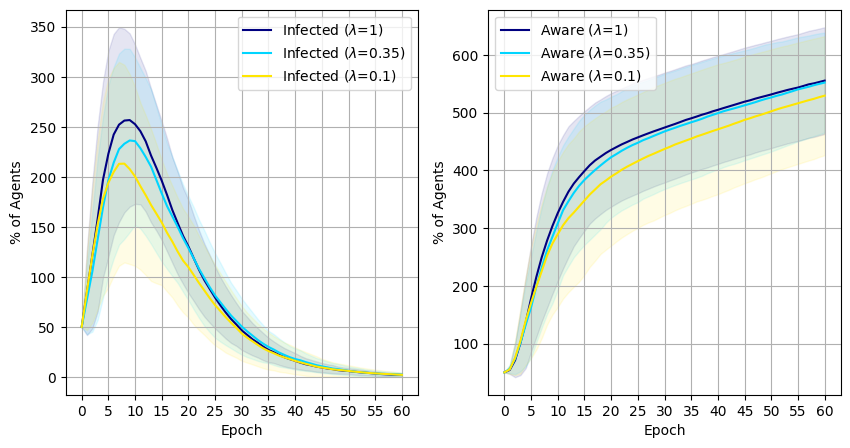

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10,5)
colors = plt.cm.jet(np.linspace(0, 1, len(results) + 1))
res_nb = 0

for l, result in results.items():

    _i = result["mean"]["I"].to_numpy()
    _i_std = result["std"]["I"].to_numpy()
    _a = result["mean"]["A"].to_numpy()
    _a_std = result["std"]["A"].to_numpy()
    _x = np.arange(0, len(_i))

    ax[0].plot(_x, _i, label=rf"Infected ($\lambda$={l})", color=colors[res_nb])
    ax[0].fill_between(_x, _i-_i_std, _i+_i_std, alpha=0.1, color=colors[res_nb])
    ax[1].plot(_x, _a, label=rf"Aware ($\lambda$={l})", color=colors[res_nb])
    ax[1].fill_between(_x, _a-_a_std, _a+_a_std, alpha=0.1, color=colors[res_nb])

    res_nb += 1

for a in ax:
    a.grid(True)
    a.set_xlabel("Epoch")
    a.set_xticks(np.arange(0, _x.max()+1, 5))
    a.set_ylabel("% of Agents")
    a.legend() #loc="upper right", bbox_to_anchor=(0.9, 0.5))
